In [52]:
import numpy as np
import random

from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from PIL import Image
import os

# generowanie sztucznego zbioru uczącego - generowanie obrazków na podstawie źródła
root_folder = '.\\F1 Teams\\'
list_of_teams = os.listdir(root_folder)
class_to_name = {}
for i, team in enumerate(list_of_teams):
    class_to_name[i] = team


def create_dataset(image_name, folder_name, number_of_samples=250):
    for i in range(number_of_samples):
        try:
            with Image.open(f".\\{folder_name}\\{image_name}") as img:
                angle = random.uniform(0, 360)
                rotated_img = img.rotate(angle, expand=True)
                augmented_path = f".\\{folder_name}\\{folder_name.split("\\")[-1]}_{i}.jpg"
                final_image = rotated_img.resize((250, 250))
                final_image.save(augmented_path)

        except Exception as e:
            print(f"Error processing {image_name}: {e}")


for root, dirs, files in os.walk(root_folder):
    for file in files:
        if file == "logo.jpg":
            create_dataset(file, f"{root}")


In [53]:
number_of_classes = 10
image_size = (250, 250)
batch_size = 32

images=[]
labels=[]

# załadowanie utworzonych danych
for team in os.listdir(root_folder):
    team_path = os.path.join(root_folder, team)

    if os.path.isdir(team_path):
        for img_file in os.listdir(team_path):
            if img_file == "logo.jpg":
                continue
            img_path = os.path.join(team_path, img_file)
            try:
                img = Image.open(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(team)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with corresponding labels.")


Loaded 2500 images with corresponding labels.


In [54]:
# przygotowanie danych
X = images / 255.0
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(labels))

# podział danych na zbiory uczące, testowe i walidacyjne
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [56]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# wprowadzenie dodatkowej losowości w zbiorach uczących
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [55]:
# definicja modelu
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(number_of_classes, activation='softmax')  # Output layer
])

model.compile(loss=keras.losses.CategoricalCrossentropy, optimizer="adam", metrics=["accuracy"])
model.summary()

C:\Users\Wojciech Grzybowski\PycharmProjects\uczenieMaszynowe\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,653,962 (105.49 MB)

 Trainable params: 27,653,962 (105.49 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# uczenie modelu
model.fit(val_generator, batch_size=32, epochs=15)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9227 - loss: 0.1898
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9549 - loss: 0.1208
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9876 - loss: 0.0454
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9970 - loss: 0.0192
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9987 - loss: 0.0160
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9856 - loss: 0.0604
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9978 - loss: 0.0136
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9848 - loss: 0.0501
Epoch 9/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 1.0000 - loss: 0.0082
Epoch 10/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 1.0000 - loss: 0.0033
Epoch 11/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 1.0000 - loss: 0.0038
Epoch 12/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 1.0000 - lo

In [65]:
# ewaluacja modelu
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Validation loss: {test_loss},\nvalidation Accuracy: {test_accuracy}")

# ręczne sprawdzenie modelu na danych spoza zbioru
# łatwy przykład - obraz wyglądający jak dane uczące
image_path = ".\\F1 teams\\test.jpg" # oczekiwana klasa: Ferrari

# przekształcenie obrazka do postaci przyjmowanej przez model
img = load_img(image_path, target_size=(250, 250))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)

predicted_class = np.argmax(prediction, axis=-1)[0]
print(f"Expected class: Ferrari")
print(f"Predicted class: {class_to_name[predicted_class]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step - accuracy: 0.9840 - loss: 0.0772
Validation loss: 0.08857407420873642,
validation Accuracy: 0.9786666631698608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Expected class: Ferrari
Predicted class: Ferrari


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step


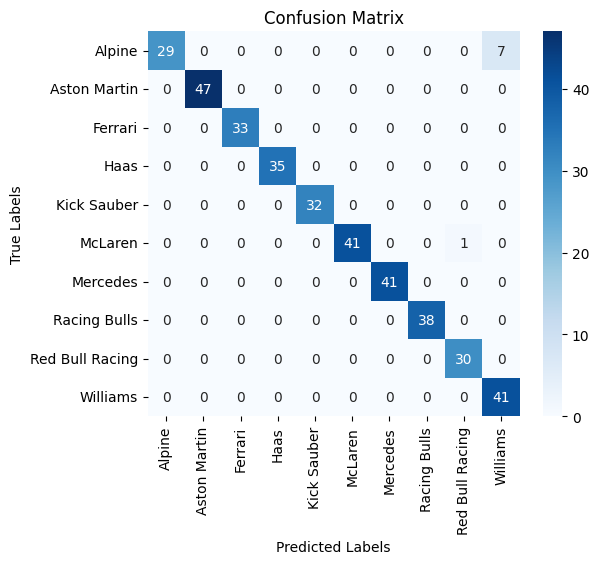

                 precision    recall  f1-score   support

         Alpine       1.00      0.81      0.89        36
   Aston Martin       1.00      1.00      1.00        47
        Ferrari       1.00      1.00      1.00        33
           Haas       1.00      1.00      1.00        35
    Kick Sauber       1.00      1.00      1.00        32
        McLaren       1.00      0.98      0.99        42
       Mercedes       1.00      1.00      1.00        41
   Racing Bulls       1.00      1.00      1.00        38
Red Bull Racing       0.97      1.00      0.98        30
       Williams       0.85      1.00      0.92        41

       accuracy                           0.98       375
      macro avg       0.98      0.98      0.98       375
   weighted avg       0.98      0.98      0.98       375



In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# wyświetlenie "confusion matrix"
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))